- 데이터셋 출처: https://github.com/e9t/nsmc/
- 영화 리뷰 데이터셋
- 학습 데이터는 문자열 형태의 리뷰(review)와, 정답 라벨(rating)으로 구성.
- 테스트 데이터는 라벨 없이 리뷰만을 담고 있습니다.
- 학습 데이터와 테스트 데이터는 각각 약 15만개와 5만개로 랜덤하게 나누어 짐.

In [1]:
#토큰화에 사용할 라이브러리
!pip install konlpy
#진행도 시각화 라이브러리
!pip install tqdm
#머신러닝 알고리즘 라이브러리
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import os, random
from tqdm import tqdm 

#재현 가능성을 위하여 랜덤 시드 고정
seed=42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

# 데이터 불러오기 및 확인

In [3]:
train_data = pd.read_csv("nsmc_train.csv", index_col=0)
test_data = pd.read_csv("nsmc_test.csv", index_col=0)
print(train_data.shape)
print(test_data.shape)

(149993, 2)
(49999, 1)


In [4]:
print (train_data['review'].nunique(), train_data['rating'].nunique())
train_data.drop_duplicates(subset=['review'], inplace=True)
print (train_data.shape)

146239 2
(146239, 2)


군형잡힌 테스트 데이터 준비

   rating  count
0       0  73081
1       1  73158


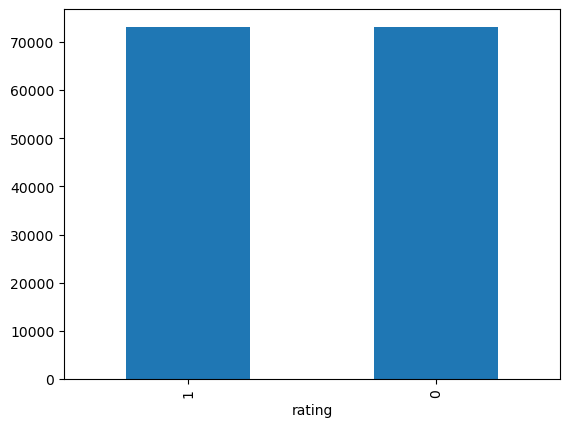

In [5]:
train_data['rating'].value_counts().plot(kind = 'bar')
print(train_data.groupby('rating').size().reset_index(name = 'count'))

In [6]:
# train data 확인
train_data.head()

,review,rating
id,,
9324809,배우들의 인생연기가 돋보였던... 최고의 드라마,1
9305425,아 혜리 보고싶다 ... 여군좀 ㅠ,0
5239110,"눈이 팅팅..... 정말 ,..... 대박이다......",1
9148159,캐슬린 터너의 보디는 볼만했다,0
6144938,진짜 최고였다.,1


In [7]:
x_train = train_data["review"]
y_train = np.array(train_data["rating"])

# 데이터 전처리
### 1.자연어 전처리
> 텍스트 데이터 전처리를 위해 정규 표현식 적용.
- 한글 문자, 영어 대문자, 영어 소문자, 띄어쓰기 이외의 문자를 제외.
- 영어의 경우 같은 단어는 같은 토큰으로 분류하기 위해 대문자로 스케일링.

In [8]:
import re

pattern = "[^가-힣A-Za-z ]"

def apply_regex(pattern, text):         # 정규표현식을 이용한 필터링 적용
    text = re.sub(pattern, "", text)    # 정규표현식 패턴에 맞는 값들을 텍스트에서 제거
    text = text.upper()                 # 영어들을 찾아 대문자로 치환하는 코드 작성
    return text

x_train_preprocessed = [apply_regex(pattern, str(x[1])) 
                                    for x in tqdm(x_train.items(), 
                                    total=len(x_train), desc="pre-processing data")]

pre-processing data: 100%|██████████| 146239/146239 [00:00<00:00, 638623.93it/s]


In [9]:
x_train_preprocessed[:20]

['배우들의 인생연기가 돋보였던 최고의 드라마',
 '아 혜리 보고싶다  여군좀 ',
 '눈이 팅팅 정말  대박이다',
 '캐슬린 터너의 보디는 볼만했다',
 '진짜 최고였다',
 '오지호 연기 징챠 잘 한다  그리고 전효성 살인사건 빨리 풀었음 ',
 '너무 충격적이다그리고 최고다',
 '상실의 시대와 맞물려 창백하게 흘러가는 청춘의 공허함 리뷰참조하세요',
 '최고 ',
 '좀 하드하고 리얼한 액션만년악당이었던 이자웅에게는 잘 어울린다',
 '아 신이구나  깜짝놀랐네 헐',
 '너무 재밌고 감동  그루 츤데레 그리고 미니언들 너무너무너무귀엽다',
 '중국산 짝퉁 냄새가 풀풀 그나마 린즈링 때문에 참는다',
 '잔인하다 근데 그뿐이다 자꾸 코믹요소를 집어넣으려고 하는 의도가 보이는건 무었일까',
 '별로',
 '묘하다',
 '평점점은 양동근씨 소속사 사장님이신가요 ',
 '세실리아와 로비의 사랑이 너무 안타깝네요',
 '쓰레기 같은 영화 주제도 없도 이딴 영화 정말 싫다',
 '이상한 것 투성인 영화 허나 바로 그 점이 매력인']

### 2. OKT를 이용한 Tokenization
- 한국어 자연어 처리 라이브러리 konlpy의 OKT(Open Korean Text)를 사용
- 문장 -> 단어 토큰화
- 추가로 어근화 진행 
> 참조: https://github.com/open-korean-text/open-korean-text

In [10]:
from konlpy.tag import Okt
okt = Okt()

def tokenize(sentence):
    sentence_tokenized = okt.morphs(sentence, stem=True)
    return sentence_tokenized

In [11]:
# 구동 환경에 따라 5 ~ 15분 정도 소요
x_train_tokenized = [tokenize(x) 
                     for x in tqdm(x_train_preprocessed, desc="tokenizing data")]
x_train_tokenized[:20]

tokenizing data: 100%|██████████| 146239/146239 [02:59<00:00, 812.54it/s] 


[['배우', '들', '의', '인생', '연기', '가', '돋보이다', '최고', '의', '드라마'],
 ['아', '혜리', '보다', '여군', '좀'],
 ['눈', '이', '팅팅', '정말', '대박', '이다'],
 ['캐슬', '린', '터너', '의', '보디', '는', '볼', '만', '하다'],
 ['진짜', '최고', '이다'],
 ['오지호', '연기', '징챠', '자다', '하다', '그리고', '전효성', '살인', '사건', '빨리', '풀다'],
 ['너무', '충격', '적', '이다', '그리고', '최고다'],
 ['상실',
  '의',
  '시대',
  '와',
  '맞다',
  '물리다',
  '창백하다',
  '흘러가다',
  '청춘',
  '의',
  '공허하다',
  '리뷰',
  '참조',
  '하다'],
 ['최고'],
 ['좀',
  '하드',
  '하고',
  '리얼',
  '한',
  '액션',
  '만년',
  '악당',
  '이다',
  '이자웅',
  '에게는',
  '자다',
  '어울리다'],
 ['아', '신', '이구나', '깜짝', '놀라다', '헐다'],
 ['너무',
  '재밌다',
  '감동',
  '그루',
  '츤데레',
  '그리고',
  '미니',
  '언',
  '들',
  '너무',
  '너무',
  '너무',
  '귀엽다'],
 ['중국산', '짝퉁', '냄새', '가', '풀풀', '그나마', '린즈링', '때문', '에', '참다'],
 ['잔인하다',
  '근데',
  '그',
  '뿐',
  '이다',
  '자꾸',
  '코믹',
  '요소',
  '를',
  '집어넣다',
  '하다',
  '의도',
  '가',
  '보이다',
  '무었일까'],
 ['별로'],
 ['묘', '하다'],
 ['평점', '점', '은', '양동근', '씨', '소속사', '사장', '님', '이신', '가요'],
 ['세실리아', '와', '로비', '의', '사랑', '이

### 3. 불용어 제거
- 리뷰의 긍정과 부정 여부를 판단하는데 필요없는 조사 등의 용어를 제거

In [12]:
#의미가 없는 불용어 리스트
stopwords = ['가', '걍', '과', '자', '잘', '들', '는', '도', '로', '를', '에', '와', '으로', '은', '이', '의', '자', '하다', '한']

def exculde_stopwords(text):
    result = [] #불용어가 제거된 텍스트
    for word in text:
        if word not in stopwords:
            result.append(word)
    return result

In [13]:
x_train_stopwords_excluded = [exculde_stopwords(x) 
                              for x in tqdm(x_train_tokenized, desc="exclude stopwords data")]
x_train_stopwords_excluded[:20]

exclude stopwords data: 100%|██████████| 146239/146239 [00:00<00:00, 359242.18it/s]


[['배우', '인생', '연기', '돋보이다', '최고', '드라마'],
 ['아', '혜리', '보다', '여군', '좀'],
 ['눈', '팅팅', '정말', '대박', '이다'],
 ['캐슬', '린', '터너', '보디', '볼', '만'],
 ['진짜', '최고', '이다'],
 ['오지호', '연기', '징챠', '자다', '그리고', '전효성', '살인', '사건', '빨리', '풀다'],
 ['너무', '충격', '적', '이다', '그리고', '최고다'],
 ['상실', '시대', '맞다', '물리다', '창백하다', '흘러가다', '청춘', '공허하다', '리뷰', '참조'],
 ['최고'],
 ['좀', '하드', '하고', '리얼', '액션', '만년', '악당', '이다', '이자웅', '에게는', '자다', '어울리다'],
 ['아', '신', '이구나', '깜짝', '놀라다', '헐다'],
 ['너무', '재밌다', '감동', '그루', '츤데레', '그리고', '미니', '언', '너무', '너무', '너무', '귀엽다'],
 ['중국산', '짝퉁', '냄새', '풀풀', '그나마', '린즈링', '때문', '참다'],
 ['잔인하다', '근데', '그', '뿐', '이다', '자꾸', '코믹', '요소', '집어넣다', '의도', '보이다', '무었일까'],
 ['별로'],
 ['묘'],
 ['평점', '점', '양동근', '씨', '소속사', '사장', '님', '이신', '가요'],
 ['세실리아', '로비', '사랑', '너무', '안타깝다'],
 ['쓰레기', '같다', '영화', '주제', '없다', '이딴', '영화', '정말', '싫다'],
 ['이상하다', '것', '투', '성인', '영화', '허다', '바로', '그', '점', '매력', '인']]

### 4. 단어 임베딩
- 토큰화와 불용어 필터를 거쳐 분리된 단어들에 대해 간단하게 one-hot encoding
- 희소 표현법으로 볼 수 있음
- *테스트 데이터에 대해서는 새로운 단어가 등장하면 값을 할당하지 않음

In [14]:
embedding_dict = dict()  # 단어 임베딩을 위한 딕셔너리
embedding_value = 0

def embed_tokens(sentence_tokenized, mode):
    assert mode.upper() in ["TRAIN", "TEST"]
    global embedding_value
    
    sentence_embedded = list()
    for word in sentence_tokenized: 
        if mode.upper() == "TRAIN":
            if word not in embedding_dict:
                embedding_dict[word] = embedding_value
                embedding_value += 1
            sentence_embedded.append(embedding_dict[word])
        elif mode.upper() == "TEST":
            if word in embedding_dict:
                sentence_embedded.append(embedding_dict[word])
            else:
                sentence_embedded.append(-1) 
    
    return sentence_embedded

In [15]:
x_train_embedded = [embed_tokens(x, mode="TRAIN") 
                    for x in tqdm(x_train_stopwords_excluded, desc="embedding data")]
print(x_train_embedded[:5])
print("total: %d words embedded."%(embedding_value))

embedding data: 100%|██████████| 146239/146239 [00:00<00:00, 257700.32it/s]

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21], [22, 4, 15]]
total: 45361 words embedded.


### 5. 문장 벡터화
- Bag of Words(BoW) 방법을 사용하여 모든 문장을 동일한 길이의 벡터로 스케일링
- BoW는 어떤 단어들이 담긴 가방(집합)의 형태로 문장을 표현한다고 볼 수 있다.
- 마치 가방 속에 든 물건의 개수를 세는 것처럼, 어떠한 문장을 고정된 m개의 단어들의 등장 횟수로 나타내는 방법이다.
- 예를 들어, "고양이는 귀엽고 강아지도 귀엽습니다."라는 문장은 다음과 같이 표현
- {"고양이":1,"귀엽":2,"고":1,"강아지":1,"는":1,"도":1,"습니다.":1, "인공지능":0, ...}

In [16]:
m = embedding_value

def to_BoW(x):
    shape = (len (x), m)
    x_BoW = np.zeros(shape) #배열 초기화
    for i in tqdm(range(len(x)), desc="To BoW"):
        for index in x[i]:
            x_BoW[i, index] += 1
    return x_BoW

In [17]:
x_train_BoW = to_BoW(x_train_embedded)
x_train_BoW[:5]

To BoW: 100%|██████████| 146239/146239 [00:00<00:00, 150255.41it/s]


array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 6. 차원 축소
- 실제로 영화 리뷰에 쓰이는 단어를 추리기 위해서 데이터의 크기를 축소
- 학습 데이터에서 50회 미만으로 등장한 단어는 제외

In [18]:
total_BoW = np.sum(x_train_BoW, axis=0)
pieces = np.where(total_BoW >= 50)[0] # 50회 미만 단어 제거
x_train_Dimension_reduction = x_train_BoW[:, pieces]
print("Original Bow Size: ", x_train_BoW.shape)
print("After Dimension reduction: ", x_train_Dimension_reduction.shape)

Original Bow Size:  (146239, 45361)
After Dimension reduction:  (146239, 3115)


In [19]:
non_zero_rows = np.any(x_train_Dimension_reduction != 0, axis=1)
x_train_Dimension_reduction_non_zero = x_train_Dimension_reduction[non_zero_rows]
y_train_non_zero = y_train[non_zero_rows]

# 분류 수행
모든 문장에 대하여 고정된 크기 m 차원의 벡터로 변환하였으니

이를 바탕으로 알고리즘에 따른 분류 모델을 만들고, 정확도 비교 평가


재현 가능성을 위해, 모든 모델의 랜덤시드는 42로 고정


In [20]:
#TEST 데이터 전처리
x_test = test_data["review"]
x_test_preprocessed = [apply_regex(pattern, str(x[1])) for x in tqdm(x_test.items(), total=len(x_test), desc="pre-processing data")]
x_test_tokenized = [tokenize(x) for x in tqdm(x_test_preprocessed, desc="tokenizing data")]
x_test_stopwords_excluded = [exculde_stopwords(x) for x in x_test_tokenized]
x_test_embedded = [embed_tokens(x, mode="TEST") for x in tqdm(x_test_stopwords_excluded, desc="embedding data")]
x_test_BoW = to_BoW(x_test_embedded)
x_test_BoW_reduced = x_test_BoW[:, pieces] #차원 감소

To BoW: 100%|██████████| 49999/49999 [00:00<00:00, 156701.07it/s]


In [21]:
import time

### 1. 로지스틱 회귀 모델

In [22]:
#로지스틱 회귀 분석
#TEST 데이터에 대한 예측 수행 코드 작성

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x_train, x_val, y_train, y_val = train_test_split(x_train_Dimension_reduction_non_zero, y_train_non_zero, test_size=0.2, random_state=42)

lr = LogisticRegression(C=1, penalty="l2", solver='saga', max_iter=500, random_state=42)
start_time = time.time()
lr.fit(x_train, y_train)

y_val_pred = lr.predict(x_val)
end_time = time.time()
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")
yTestPred = lr.predict(x_test_BoW_reduced)

c:\Users\kbg46\anaconda3\envs\condatest\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation Accuracy: 0.8293577981651377
Confusion Matrix:
[[12049  2354]
 [ 2575 11907]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     14403
           1       0.83      0.82      0.83     14482

    accuracy                           0.83     28885
   macro avg       0.83      0.83      0.83     28885
weighted avg       0.83      0.83      0.83     28885

Training + Predicting Time: 853.6588 seconds


### 2. SVM, 서포트 벡터 머신

In [23]:
#서포트 벡터 머신
#TEST 데이터에 대한 예측 수행 코드 작성
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_Dimension_reduction_non_zero, y_train_non_zero, test_size=0.2, random_state=42
)

# 서포트 벡터 머신 모델 정의 및 학습
svm = SVC(kernel='linear', C=1.0, max_iter=500, random_state=42)
start_time = time.time()
svm.fit(x_train, y_train)

# Validation 데이터에 대한 예측
y_val_pred = svm.predict(x_val)
end_time = time.time()
# 평가 지표 계산
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

# 결과 출력
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")

# Test 데이터에 대한 예측
yTestPred = svm.predict(x_test_BoW_reduced)

c:\Users\kbg46\anaconda3\envs\condatest\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.5369568980439675
Confusion Matrix:
[[ 2877 11526]
 [ 1849 12633]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.20      0.30     14403
           1       0.52      0.87      0.65     14482

    accuracy                           0.54     28885
   macro avg       0.57      0.54      0.48     28885
weighted avg       0.57      0.54      0.48     28885

Training + Predicting Time: 155.8141 seconds


### 3. 다층퍼셉트론, Neural Networks (MLPClassifier)

In [24]:
#다층퍼셉트론론
#TEST 데이터에 대한 예측 수행 코드 작성
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_Dimension_reduction_non_zero, y_train_non_zero, test_size=0.2, random_state=42
)

# 다층퍼셉트론 모델 정의 및 학습
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
start_time = time.time()
mlp.fit(x_train, y_train)

# Validation 데이터에 대한 예측
y_val_pred = mlp.predict(x_val)
end_time = time.time()
# 평가 지표 계산
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred)

# 결과 출력
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")

# Test 데이터에 대한 예측
yTestPred = mlp.predict(x_test_BoW_reduced)

Validation Accuracy: 0.8241647914142288
Confusion Matrix:
[[11977  2426]
 [ 2653 11829]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     14403
           1       0.83      0.82      0.82     14482

    accuracy                           0.82     28885
   macro avg       0.82      0.82      0.82     28885
weighted avg       0.82      0.82      0.82     28885

Training + Predicting Time: 615.1094 seconds


### 문장 벡터화 심화 - TF-IDF 적용
- BoW에서는 각 단어들의 중요도를 고려하지 않는다
- 이를 보완하고자 TF-IDF를 적용해본다.

In [25]:
#총 데이터 샘플의 수
N = len(x_train_Dimension_reduction_non_zero)

#어떤 단어가 등장하는 데이터 샘플의 수(DF)를 계산
def calculate_document_frequency(x):
    bool_arr = (x>0)
    return bool_arr.sum(axis=0)

#DF에 반비례하는 IDF 계산
def calculate_inverse_document_frequency(document_frequency):
    inverse_doc_freq = np.log(N / (document_frequency + 1))
    return inverse_doc_freq

document_frequency = calculate_document_frequency(x_train_Dimension_reduction_non_zero)
inverse_document_frequency = calculate_inverse_document_frequency(document_frequency)

#데이터에 IDF 값 적용
x_train_TF_IDF = x_train_Dimension_reduction * inverse_document_frequency

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# 데이터 분할
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_Dimension_reduction_non_zero, y_train_non_zero, test_size=0.2, random_state=42
)

# TF-IDF 적용
x_train_TF_IDF = x_train_split * inverse_document_frequency
x_val_TF_IDF = x_val_split * inverse_document_frequency

# 서포트 벡터 머신 모델 정의
svm = SVC(kernel='linear', C=1.0, max_iter=500, random_state=42)

# 모델 학습
start_time = time.time()
svm.fit(x_train_TF_IDF, y_train_split)

# Validation 데이터에 대한 예측
y_val_pred = svm.predict(x_val_TF_IDF)
end_time = time.time()

# 평가 지표 계산
accuracy = accuracy_score(y_val_split, y_val_pred)
conf_matrix = confusion_matrix(y_val_split, y_val_pred)
class_report = classification_report(y_val_split, y_val_pred)

# 결과 출력
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")


c:\Users\kbg46\anaconda3\envs\condatest\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.5523974381166695
Confusion Matrix:
[[ 3385 11018]
 [ 1911 12571]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.24      0.34     14403
           1       0.53      0.87      0.66     14482

    accuracy                           0.55     28885
   macro avg       0.59      0.55      0.50     28885
weighted avg       0.59      0.55      0.50     28885

Training + Predicting Time: 159.9837 seconds


### class_weight='balanced'옵션을 통한 클래스 가중치 조정

In [27]:
# 서포트 벡터 머신 모델 정의
svm = SVC(kernel='linear', C=1.0, max_iter=500, random_state=42, class_weight='balanced')

# 모델 학습
start_time = time.time()
svm.fit(x_train_TF_IDF, y_train_split)

# Validation 데이터에 대한 예측
y_val_pred = svm.predict(x_val_TF_IDF)
end_time = time.time()

# 평가 지표 계산
accuracy = accuracy_score(y_val_split, y_val_pred)
conf_matrix = confusion_matrix(y_val_split, y_val_pred)
class_report = classification_report(y_val_split, y_val_pred)

# 결과 출력
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")

c:\Users\kbg46\anaconda3\envs\condatest\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.5523974381166695
Confusion Matrix:
[[ 3385 11018]
 [ 1911 12571]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.24      0.34     14403
           1       0.53      0.87      0.66     14482

    accuracy                           0.55     28885
   macro avg       0.59      0.55      0.50     28885
weighted avg       0.59      0.55      0.50     28885

Training + Predicting Time: 161.3268 seconds


### 하이퍼 파라미터 최적화 작업

In [29]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 하이퍼파라미터 그리드 정의
param_grid = {'C': [0.1, 1, 10]}

# GridSearchCV로 하이퍼파라미터 튜닝
grid_search = GridSearchCV(LinearSVC(class_weight='balanced', random_state=42, max_iter=1000), param_grid, cv=3, n_jobs=-1)

# 학습 시작 시간 기록
start_time = time.time()
grid_search.fit(x_train_TF_IDF, y_train_split)
end_time = time.time()

# 최적의 하이퍼파라미터와 정확도 출력
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Cross-validation Score: ", best_score)

# 최적 모델로 예측 수행
svm_best = grid_search.best_estimator_
y_val_pred = svm_best.predict(x_val_TF_IDF)

# 예측 결과 평가
accuracy = accuracy_score(y_val_split, y_val_pred)
conf_matrix = confusion_matrix(y_val_split, y_val_pred)
class_report = classification_report(y_val_split, y_val_pred)

# 결과 출력
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# 학습 + 예측 시간 출력
print(f"Training + Predicting Time: {end_time - start_time:.4f} seconds")


Best Parameters:  {'C': 0.1}
Best Cross-validation Score:  0.8257486593460529
Validation Accuracy: 0.8275575558248226
Confusion Matrix:
[[12032  2371]
 [ 2610 11872]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     14403
           1       0.83      0.82      0.83     14482

    accuracy                           0.83     28885
   macro avg       0.83      0.83      0.83     28885
weighted avg       0.83      0.83      0.83     28885

Training + Predicting Time: 34.7169 seconds
